# loading Fashion MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [4]:
from keras.utils import to_categorical

y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

y_train_onehot.shape , y_test_onehot.shape

((60000, 10), (10000, 10))

In [5]:
from keras.layers import Flatten , Rescaling , Input  
from keras.models import Model

input_layer = Input(shape=(28,28))

x = Rescaling(1.0/255.0)(input_layer)

x = Flatten()(x)

Transform = Model(inputs=input_layer, outputs=x)
Transform.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
x_train_tr = Transform(x_train)
x_test_tr = Transform(x_test)
x_train_tr.shape , x_test_tr.shape

(TensorShape([60000, 784]), TensorShape([10000, 784]))

# tuning Hyper Parameters using Random Search

In [7]:
from keras.layers import Dense , Dropout , BatchNormalization
from keras import activations
from keras.optimizers import Adam

In [8]:
def Model_init(hp):
    Number_hidden  = hp.Int('Number_hidden', min_value=0, max_value=7, step=1)
    Neurons = hp.Int('Neurons', min_value=32, max_value=256, step=16)
    Dropout_rate =hp.Float('Dropout_rate', min_value=0.05, max_value=0.55, step=0.05)
    Learning_rate = hp.Float('Learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    input_layer = Input((784,))
    x = Dense(Neurons , activation = activations.relu)(input_layer)
    x = Dropout(Dropout_rate)(x)
    x = BatchNormalization()(x)
    for i in range(Number_hidden-1):
        x = Dense(Neurons)(x)
        x = Dropout(Dropout_rate)(x)
        x = BatchNormalization()(x)
    
    output_layer = Dense(10 , activation = activations.softmax)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate = Learning_rate) , 
                  loss = tf.losses.CategoricalCrossentropy , metrics = ['Accuracy'])

    return model


In [15]:
from keras_tuner import HyperParameters, RandomSearch

In [19]:
tuner = RandomSearch(Model_init , objective='val_Accuracy',  max_trials=10, directory='random_search', 
                     project_name='fashion_mnist_random_search_10')

In [20]:
tuner.search(x_train_tr, y_train_onehot, epochs=5 , batch_size = 32, validation_data=(x_test_tr, y_test_onehot))

Trial 10 Complete [00h 02m 29s]
val_Accuracy: 0.8349999785423279

Best val_Accuracy So Far: 0.8543000221252441
Total elapsed time: 00h 33m 50s


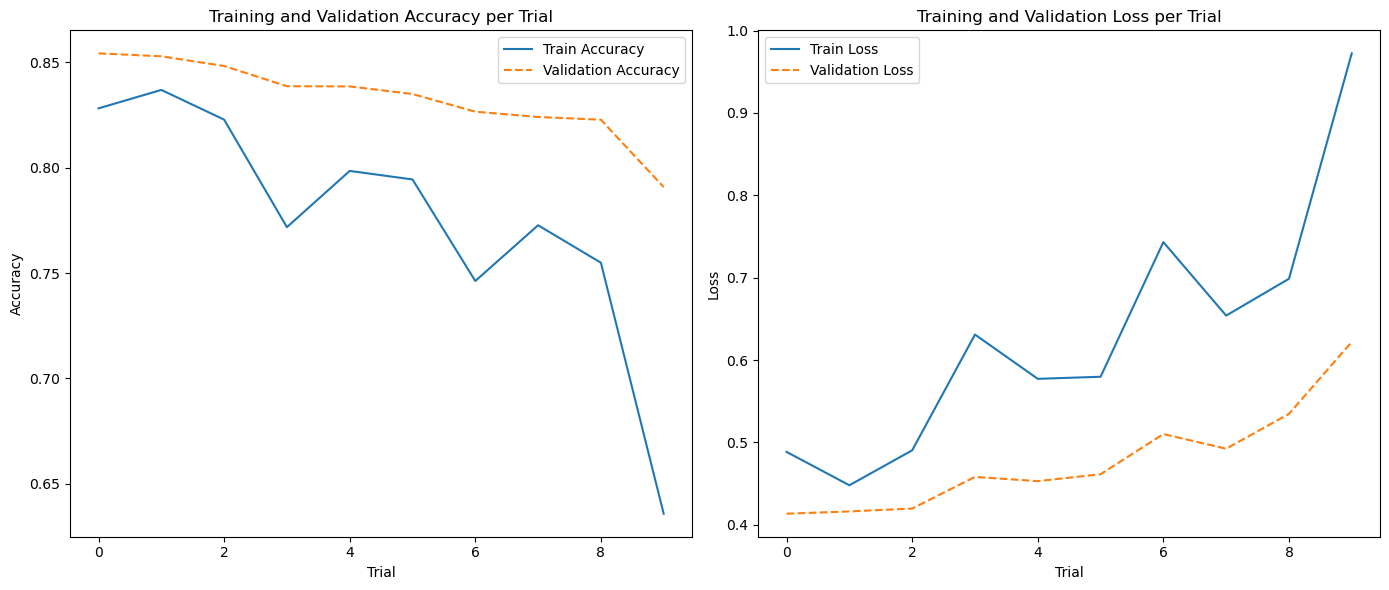

In [24]:
import matplotlib.pyplot as plt


trials = tuner.oracle.get_best_trials(num_trials=10) 


train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []


for trial in trials:
    train_acc = trial.metrics.get_last_value("Accuracy")
    val_acc = trial.metrics.get_last_value("val_Accuracy")
    train_loss = trial.metrics.get_last_value("loss")
    val_loss = trial.metrics.get_last_value("val_loss")

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Trial')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Trial')
plt.legend()

plt.tight_layout()
plt.show()

## Fitting The results on the best found Model 

In [32]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
model = Model_init(best_hyperparameters)

In [33]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,634 (2.05 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [34]:
hist = model.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=20, 
                         batch_size=32)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - Accuracy: 0.6197 - loss: 1.0966 - val_Accuracy: 0.8273 - val_loss: 0.4883
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - Accuracy: 0.7857 - loss: 0.6128 - val_Accuracy: 0.8238 - val_loss: 0.4745
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - Accuracy: 0.8099 - loss: 0.5413 - val_Accuracy: 0.8411 - val_loss: 0.4491
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - Accuracy: 0.8215 - loss: 0.5093 - val_Accuracy: 0.8505 - val_loss: 0.4214
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - Accuracy: 0.8284 - loss: 0.4900 - val_Accuracy: 0.8520 - val_loss: 0.4119
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - Accuracy: 0.8317 - loss: 0.4772 - val_Accuracy: 0.8578 - val_loss: 0.4009
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - Accuracy: 0.8373 - loss: 0.4588 - val_Accuracy: 0.8584 - val_loss: 0.3901
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - Accuracy: 0.8375 -

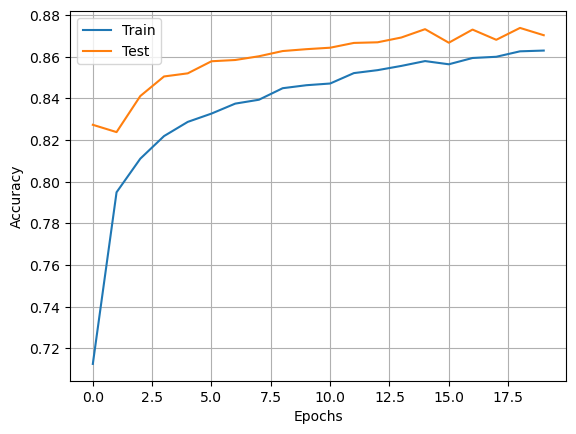

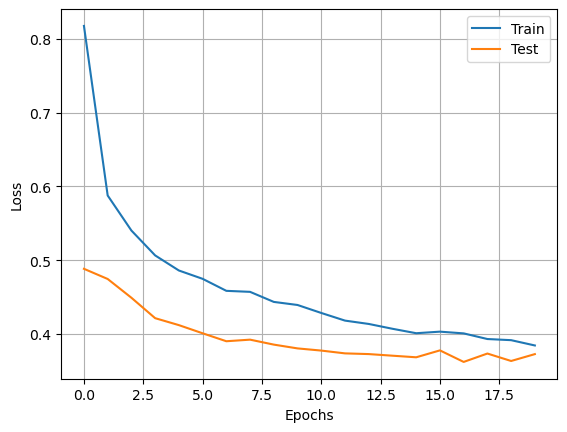

In [39]:
plt.plot(hist.history['Accuracy'] , label = "Train")
plt.plot(hist.history['val_Accuracy'] , label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()



plt.plot(hist.history['loss'] , label = "Train")
plt.plot(hist.history['val_loss'] , label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

## Changing Hyper paramters using Hand 

In [40]:
def Model_init_h( Number_hidden ,  Neurons , Dropout_rate, Learning_rate ):
    input_layer = Input((784,))
    x = Dense(Neurons , activation = activations.relu)(input_layer)
    x = Dropout(Dropout_rate)(x)
    x = BatchNormalization()(x)
    for i in range(Number_hidden-1):
        x = Dense(Neurons)(x)
        x = Dropout(Dropout_rate)(x)
        x = BatchNormalization()(x)
    
    output_layer = Dense(10 , activation = activations.softmax)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate = Learning_rate) , 
                  loss = tf.losses.CategoricalCrossentropy , metrics = ['Accuracy'])

    return model


## changing Learning Rates only

In [41]:
model_1 = Model_init_h(1 , 48 , 0.1 , 0.001)
model_2 = Model_init_h(1 , 48 , 0.1 , 0.01)
model_3 = Model_init_h(1 , 48 , 0.1 , 0.1)

In [42]:
hist_1 = model_1.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=5, 
                         batch_size=32)

hist_2 = model_2.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=5, 
                         batch_size=32)

hist_3 = model_2.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=5, 
                         batch_size=32)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.7613 - loss: 0.7084 - val_Accuracy: 0.8373 - val_loss: 0.4542
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - Accuracy: 0.8363 - loss: 0.4625 - val_Accuracy: 0.8418 - val_loss: 0.4424
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - Accuracy: 0.8476 - loss: 0.4293 - val_Accuracy: 0.8427 - val_loss: 0.4417
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.8537 - loss: 0.4088 - val_Accuracy: 0.8578 - val_loss: 0.3921
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.8589 - loss: 0.3871 - val_Accuracy: 0.8534 - val_loss: 0.4074
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - Accuracy: 0.7629 - loss: 0.6737 - val_Accuracy: 0.7905 - val_loss: 0.5912
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - Accuracy: 0.8225 - loss: 0.4924 - val_Accuracy: 0.8364 - val_loss: 0.4776
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.8327 - loss: 0

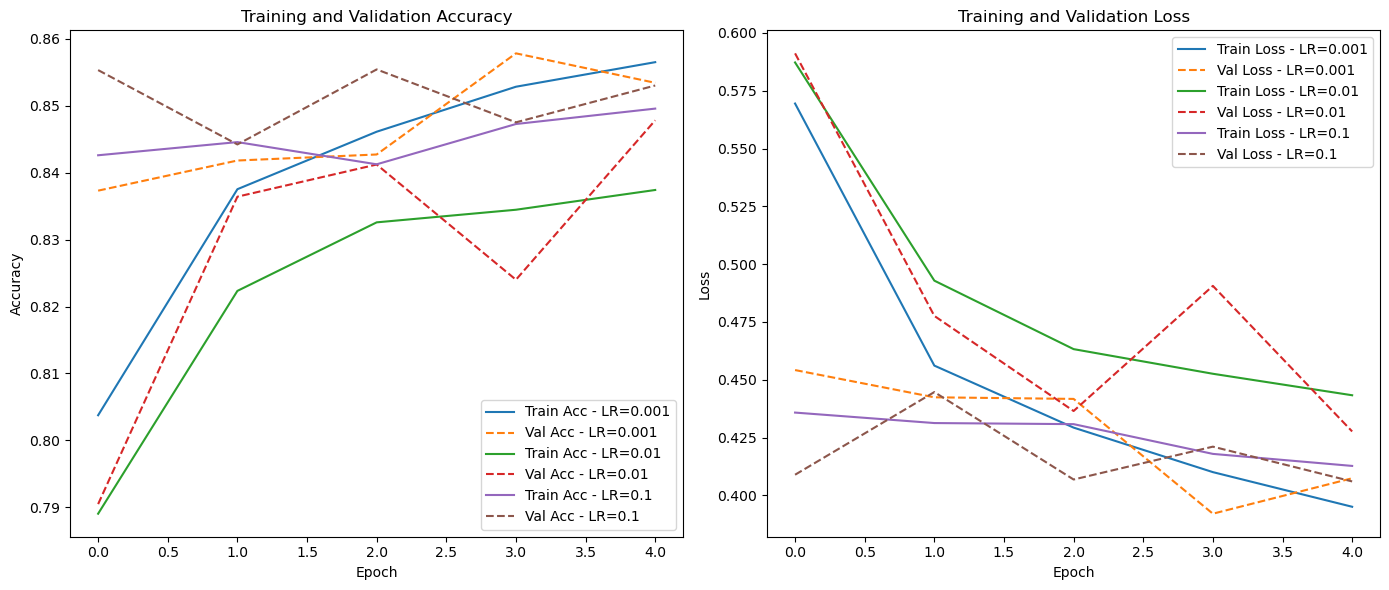

In [43]:
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(hist_1.history['Accuracy'], label='Train Acc - LR=0.001')
plt.plot(hist_1.history['val_Accuracy'], label='Val Acc - LR=0.001', linestyle='--')
plt.plot(hist_2.history['Accuracy'], label='Train Acc - LR=0.01')
plt.plot(hist_2.history['val_Accuracy'], label='Val Acc - LR=0.01', linestyle='--')
plt.plot(hist_3.history['Accuracy'], label='Train Acc - LR=0.1')
plt.plot(hist_3.history['val_Accuracy'], label='Val Acc - LR=0.1', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(hist_1.history['loss'], label='Train Loss - LR=0.001')
plt.plot(hist_1.history['val_loss'], label='Val Loss - LR=0.001', linestyle='--')
plt.plot(hist_2.history['loss'], label='Train Loss - LR=0.01')
plt.plot(hist_2.history['val_loss'], label='Val Loss - LR=0.01', linestyle='--')
plt.plot(hist_3.history['loss'], label='Train Loss - LR=0.1')
plt.plot(hist_3.history['val_loss'], label='Val Loss - LR=0.1', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


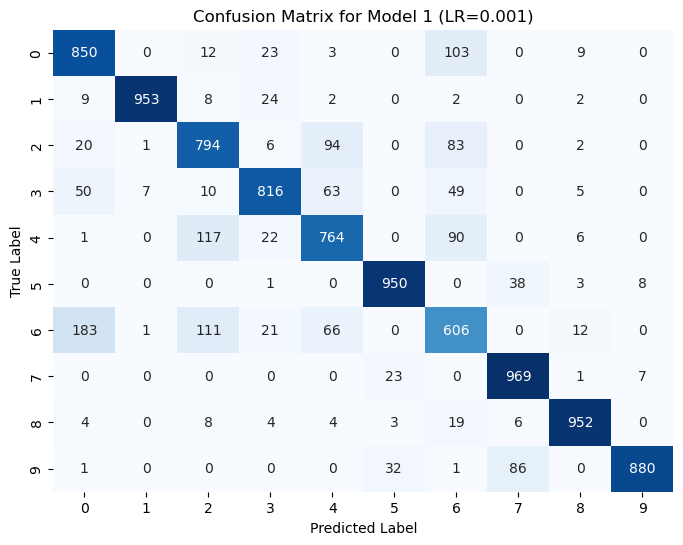

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


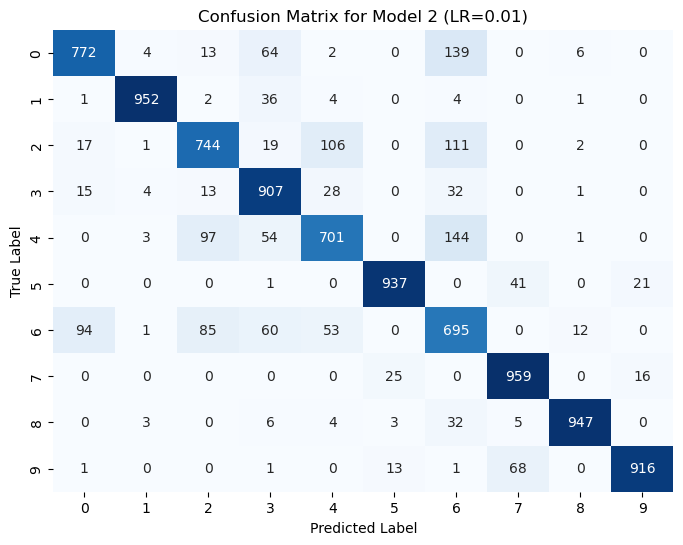

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


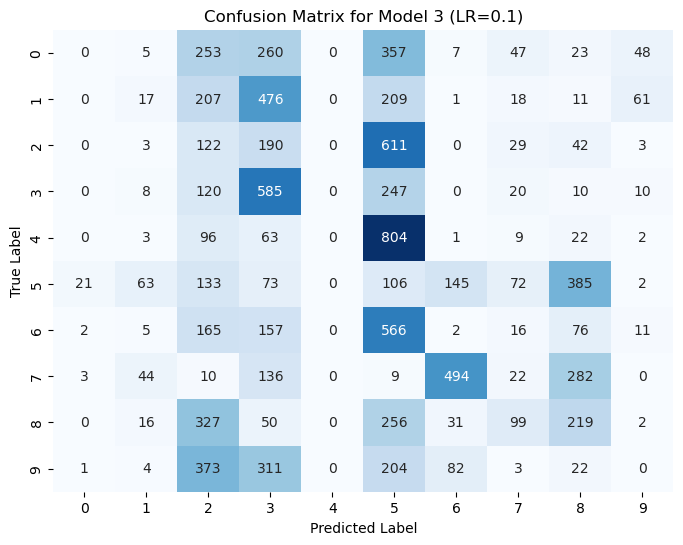

In [45]:
y_true = np.argmax(y_test_onehot, axis=1)

y_pred_1 = np.argmax(model_1.predict(x_test_tr), axis=1)
plot_confusion_matrix(y_true, y_pred_1, "Model 1 (LR=0.001)")

y_pred_2 = np.argmax(model_2.predict(x_test_tr), axis=1)
plot_confusion_matrix(y_true, y_pred_2, "Model 2 (LR=0.01)")

y_pred_3 = np.argmax(model_3.predict(x_test_tr), axis=1)
plot_confusion_matrix(y_true, y_pred_3, "Model 3 (LR=0.1)")

# changing number of neurons only

In [46]:
model_1 = Model_init_h(1 , 24 , 0.1 , 0.001)
model_2 = Model_init_h(1 , 48 , 0.1 , 0.001)
model_3 = Model_init_h(1 , 84 , 0.1 , 0.001)

hist_1 = model_1.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=5, 
                         batch_size=32)

hist_2 = model_2.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=5, 
                         batch_size=32)

hist_3 = model_2.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=5, 
                         batch_size=32)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - Accuracy: 0.7311 - loss: 0.8562 - val_Accuracy: 0.8413 - val_loss: 0.4624
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.8247 - loss: 0.4881 - val_Accuracy: 0.8377 - val_loss: 0.4498
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - Accuracy: 0.8380 - loss: 0.4469 - val_Accuracy: 0.8434 - val_loss: 0.4472
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - Accuracy: 0.8430 - loss: 0.4379 - val_Accuracy: 0.8471 - val_loss: 0.4382
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - Accuracy: 0.8418 - loss: 0.4443 - val_Accuracy: 0.8514 - val_loss: 0.4250
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - Accuracy: 0.7648 - loss: 0.7034 - val_Accuracy: 0.8336 - val_loss: 0.4711
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.8375 - loss: 0.4583 - val_Accuracy: 0.8458 - val_loss: 0.4376
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.8516 - loss: 0

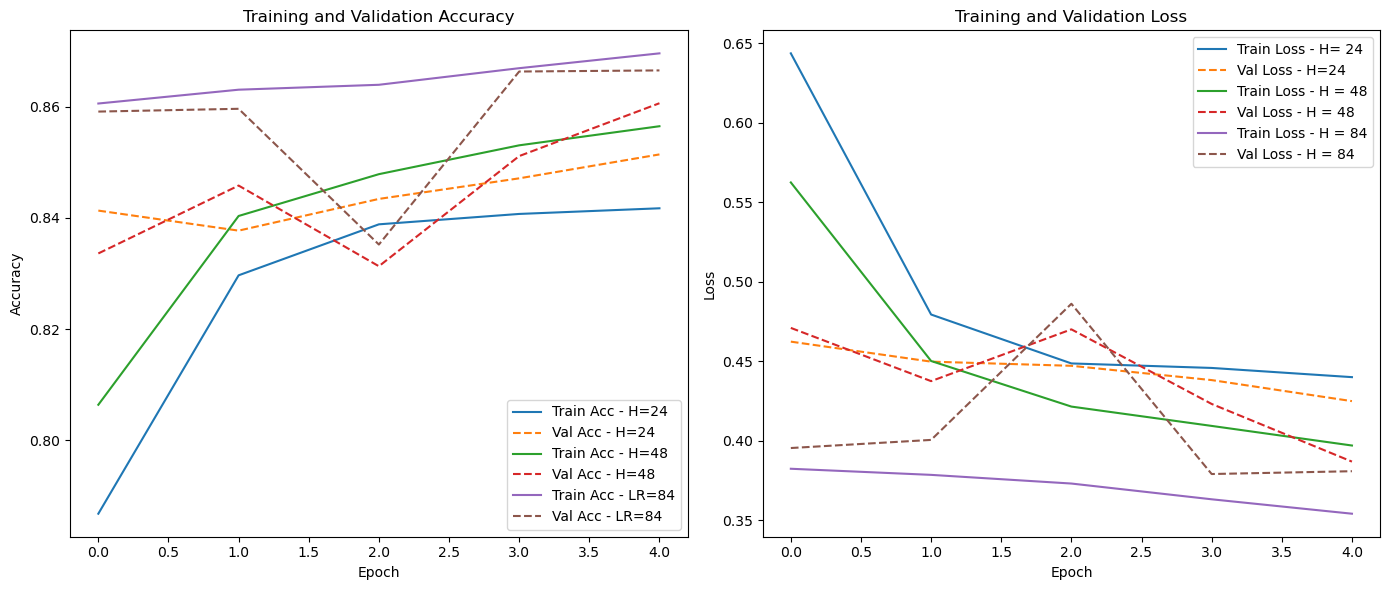

In [48]:
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(hist_1.history['Accuracy'], label='Train Acc - H=24')
plt.plot(hist_1.history['val_Accuracy'], label='Val Acc - H=24', linestyle='--')
plt.plot(hist_2.history['Accuracy'], label='Train Acc - H=48')
plt.plot(hist_2.history['val_Accuracy'], label='Val Acc - H=48', linestyle='--')
plt.plot(hist_3.history['Accuracy'], label='Train Acc - LR=84')
plt.plot(hist_3.history['val_Accuracy'], label='Val Acc - LR=84', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(hist_1.history['loss'], label='Train Loss - H= 24')
plt.plot(hist_1.history['val_loss'], label='Val Loss - H=24', linestyle='--')
plt.plot(hist_2.history['loss'], label='Train Loss - H = 48')
plt.plot(hist_2.history['val_loss'], label='Val Loss - H = 48', linestyle='--')
plt.plot(hist_3.history['loss'], label='Train Loss - H = 84')
plt.plot(hist_3.history['val_loss'], label='Val Loss - H = 84', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


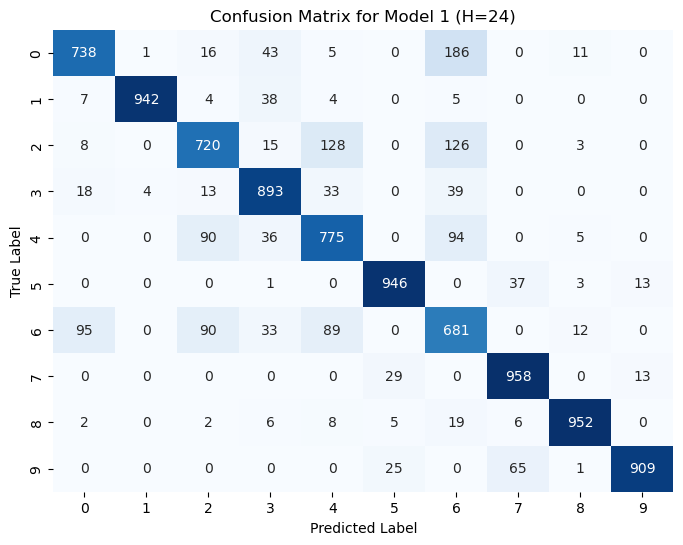

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


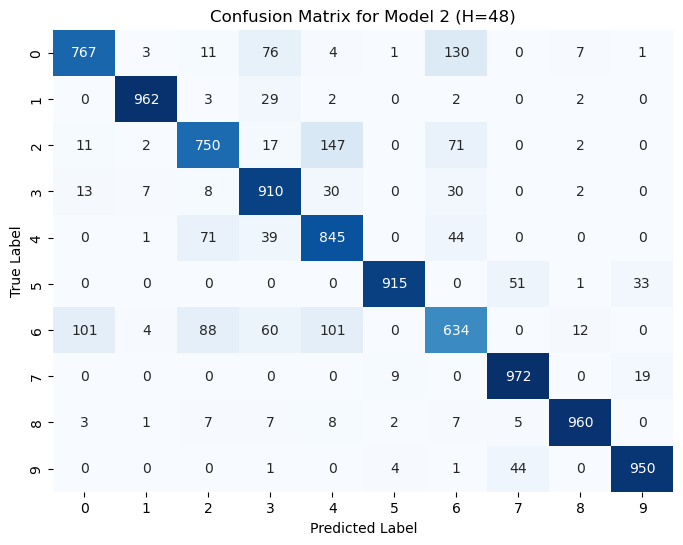

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


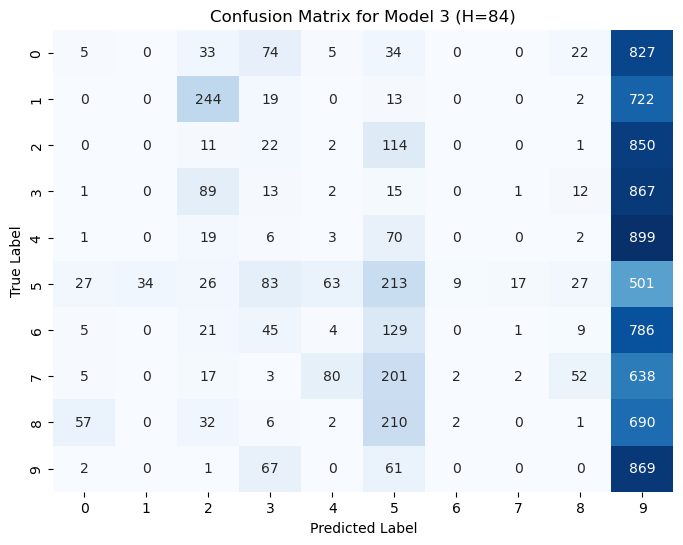

In [50]:
y_true = np.argmax(y_test_onehot, axis=1)

y_pred_1 = np.argmax(model_1.predict(x_test_tr), axis=1)
plot_confusion_matrix(y_true, y_pred_1, "Model 1 (H=24)")

y_pred_2 = np.argmax(model_2.predict(x_test_tr), axis=1)
plot_confusion_matrix(y_true, y_pred_2, "Model 2 (H=48)")

y_pred_3 = np.argmax(model_3.predict(x_test_tr), axis=1)
plot_confusion_matrix(y_true, y_pred_3, "Model 3 (H=84)")

# Changing Numebr of layers

In [51]:
model_1 = Model_init_h(1 , 48 , 0.1 , 0.001)
model_2 = Model_init_h(2 , 48 , 0.1 , 0.001)
model_3 = Model_init_h(3 , 48 , 0.1 , 0.001)

hist_1 = model_1.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=5, 
                         batch_size=32)

hist_2 = model_2.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=5, 
                         batch_size=32)

hist_3 = model_2.fit(x_train_tr,y_train_onehot , 
                         validation_data=(x_test_tr, y_test_onehot),
                         epochs=5, 
                         batch_size=32)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - Accuracy: 0.7687 - loss: 0.6936 - val_Accuracy: 0.8253 - val_loss: 0.4836
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.8330 - loss: 0.4668 - val_Accuracy: 0.8312 - val_loss: 0.4817
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.8486 - loss: 0.4300 - val_Accuracy: 0.8445 - val_loss: 0.4314
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - Accuracy: 0.8512 - loss: 0.4120 - val_Accuracy: 0.8557 - val_loss: 0.3930
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - Accuracy: 0.8587 - loss: 0.3985 - val_Accuracy: 0.8362 - val_loss: 0.4432
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - Accuracy: 0.7550 - loss: 0.7136 - val_Accuracy: 0.8105 - val_loss: 0.5467
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - Accuracy: 0.8273 - loss: 0.4828 - val_Accuracy: 0.8374 - val_loss: 0.4523
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - Accuracy: 0.8354 - loss: 0

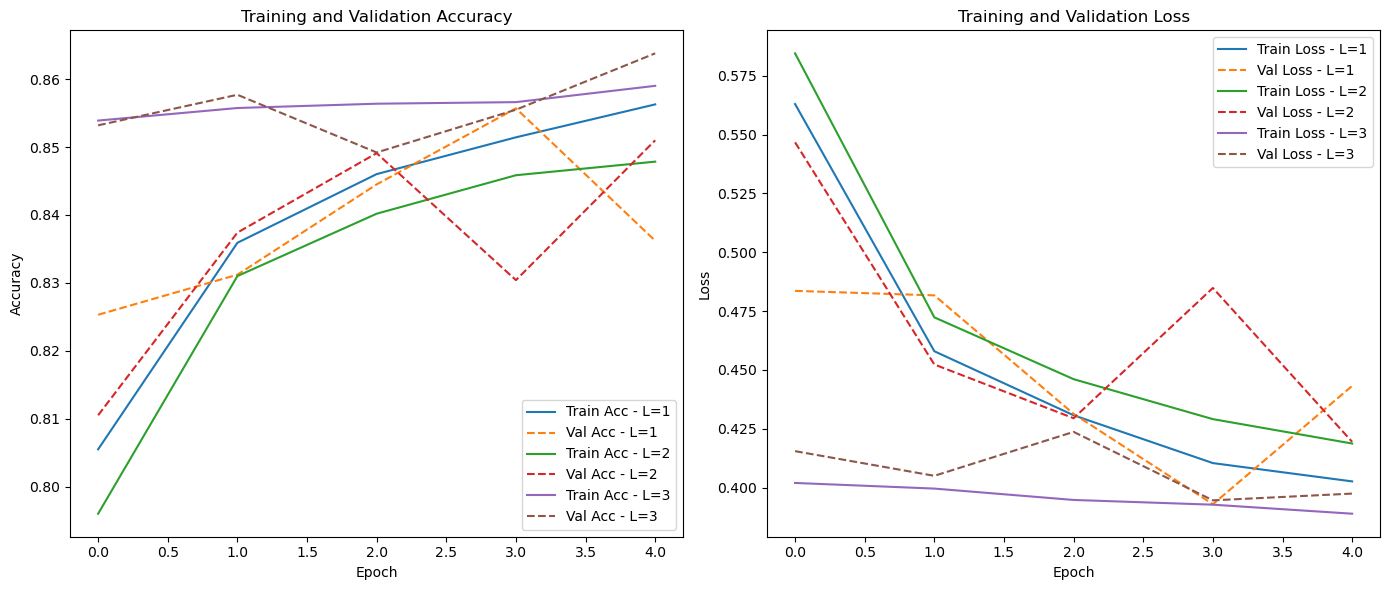

In [52]:
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(hist_1.history['Accuracy'], label='Train Acc - L=1')
plt.plot(hist_1.history['val_Accuracy'], label='Val Acc - L=1', linestyle='--')
plt.plot(hist_2.history['Accuracy'], label='Train Acc - L=2')
plt.plot(hist_2.history['val_Accuracy'], label='Val Acc - L=2', linestyle='--')
plt.plot(hist_3.history['Accuracy'], label='Train Acc - L=3')
plt.plot(hist_3.history['val_Accuracy'], label='Val Acc - L=3', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(hist_1.history['loss'], label='Train Loss - L=1')
plt.plot(hist_1.history['val_loss'], label='Val Loss - L=1', linestyle='--')
plt.plot(hist_2.history['loss'], label='Train Loss - L=2')
plt.plot(hist_2.history['val_loss'], label='Val Loss - L=2', linestyle='--')
plt.plot(hist_3.history['loss'], label='Train Loss - L=3')
plt.plot(hist_3.history['val_loss'], label='Val Loss - L=3', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


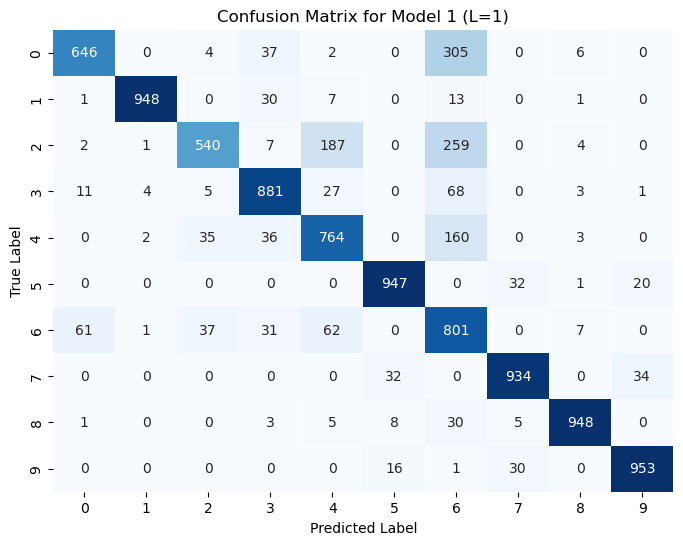

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


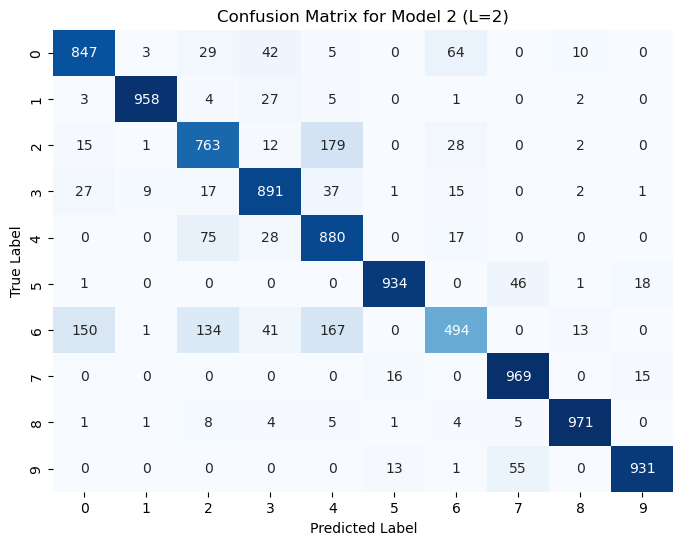

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


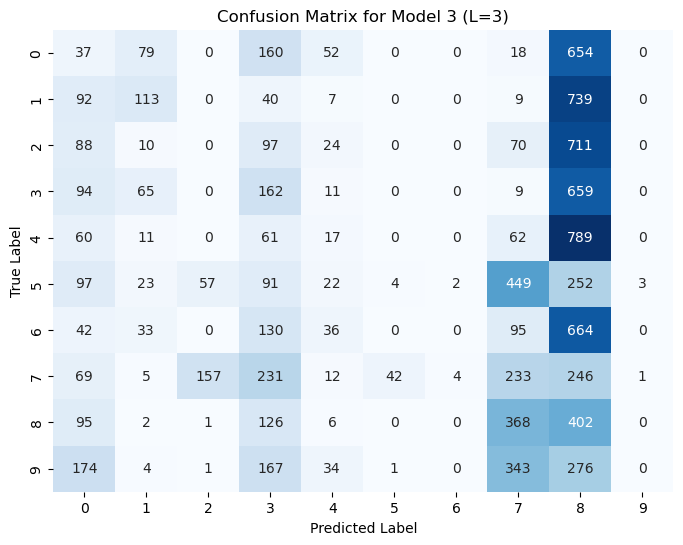

In [53]:
y_true = np.argmax(y_test_onehot, axis=1)

y_pred_1 = np.argmax(model_1.predict(x_test_tr), axis=1)
plot_confusion_matrix(y_true, y_pred_1, "Model 1 (L=1)")

y_pred_2 = np.argmax(model_2.predict(x_test_tr), axis=1)
plot_confusion_matrix(y_true, y_pred_2, "Model 2 (L=2)")

y_pred_3 = np.argmax(model_3.predict(x_test_tr), axis=1)
plot_confusion_matrix(y_true, y_pred_3, "Model 3 (L=3)")